In [17]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, Subset # Subset 추가
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold # StratifiedKFold 추가
import matplotlib.pyplot as plt
import seaborn as sns

# Weights & Biases (wandb) 임포트
import wandb

# Mixup 및 SoftTargetCrossEntropy를 위한 timm 임포트
from timm.data import Mixup
from timm.data.transforms_factory import create_transform
from timm.loss import SoftTargetCrossEntropy
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR # <--- Add this import
from torch.optim.lr_scheduler import CosineAnnealingLR # <--- Add this import


In [18]:

# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True


In [19]:

# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv_file, path, transform=None, return_raw=False):
        self.df = pd.read_csv(csv_file)
        self.path = path
        self.transform = transform
        self.return_raw = return_raw

        # 필수 컬럼 존재 여부 확인
        if 'ID' not in self.df.columns:
            raise ValueError(f"CSV 파일 '{csv_file}'에 'ID' 컬럼이 없습니다.")
        if 'target' not in self.df.columns:
            raise ValueError(f"CSV 파일 '{csv_file}'에 'target' 컬럼이 없습니다.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'ID']
        target = self.df.loc[idx, 'target']

        img_path = os.path.join(self.path, img_name)
        
        if not os.path.exists(img_path):
            print(f"경고: 이미지 파일이 존재하지 않습니다: {img_path}. 이 항목은 건너뛰거나 에러가 발생할 수 있습니다.", flush=True)

        if self.return_raw:
            img = np.array(Image.open(img_path).convert('RGB'))
            return img, target
        else:
            if self.transform:
                if hasattr(self.transform, '__module__') and 'torchvision.transforms' in self.transform.__module__:
                    img = Image.open(img_path).convert('RGB')
                    img = self.transform(img)
                else:
                    img = np.array(Image.open(img_path).convert('RGB'))
                    img = self.transform(image=img)['image']
            else:
                img = np.array(Image.open(img_path).convert('RGB'))

            return img, target


In [20]:

# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device, mixup_fn=None):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        if mixup_fn is not None:
            image, targets = mixup_fn(image, targets)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        
        if mixup_fn is not None:
            targets_list.extend(targets.argmax(dim=1).detach().cpu().numpy())
        else:
            targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}\n")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "loss": train_loss,
        "accuracy": train_acc,
        "train_f1": train_f1,
    }

    return ret


In [21]:

def validate_one_epoch(loader, model, loss_fn, device='cuda'):
    """
    한 에포크 검증 함수
    """
    model.eval()
    
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(pbar):
            images = images.to(device)
            targets = targets.to(device) 

            targets_one_hot = F.one_hot(targets.to(torch.int64), num_classes=NUM_CLASSES).float()
            
            outputs = model(images)
            
            loss = loss_fn(outputs, targets_one_hot)
            
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            current_loss = total_loss / (batch_idx + 1)
            current_acc = 100. * correct / total
            pbar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.2f}%'
            })
    
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'total_samples': total,
        'correct_samples': correct
    }


In [ ]:

# Early Stopping 클래스
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights and self.best_weights is not None:
                    model.load_state_dict(self.best_weights)
                    print(f"🔄 Best weights restored (loss: {self.best_loss:.4f})", flush=True)
                return True
            return False


In [24]:

# --- Hyper-parameters ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = 'data/train_aug/'
train_csv_file = "data/train_augmented.csv" # 전체 학습 데이터 CSV
test_csv = "data/sample_submission.csv" # 테스트셋 CSV 파일 경로 (검증 로더에 사용)
test_path = "data/test/" # 테스트 이미지 경로 (검증 로더에 사용)

# model_name = 'convnext_base' # 사용할 모델 이름
model_name = 'efficientnet_b5'

img_size = 456
LR = 1e-3
WEIGHT_DECAY = 1e-4

EPOCHS = 10 # 각 폴드별 에포크 수
BATCH_SIZE = 12
num_workers = 0

USE_AUTO_AUGMENT = False
AUTO_AUGMENT_NAME = 'rand-m9-mstd0.5'

USE_MIXUP = False
MIXUP_ALPHA = 0.8
CUTMIX_ALPHA = 1.0
MIXUP_PROB = 0.5
SWITCH_PROB = 0.5
LABEL_SMOOTHING_EPS = 0.1
NUM_CLASSES = 17

# K-Fold Cross-Validation Parameters
N_SPLITS = 5 # 폴드 개수


In [25]:

# --- Data Transforms ---
if USE_AUTO_AUGMENT:
    trn_transform = create_transform(
        input_size=img_size,
        is_training=True,
        hflip=0.5,
        color_jitter=0.4,
        auto_augment=AUTO_AUGMENT_NAME,
        interpolation='bicubic',
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        re_prob=0.0,
    )
else:
    trn_transform = A.Compose([
        A.Resize(height=img_size, width=img_size),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=1.0),
        # A.CoarseDropout(p=1.0),
        # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=0, p=1.0),
        # A.RandomCrop(height=200, width=200, p=1.0),
        # A.MotionBlur(blur_limit=3, p=1.0),
        # A.MotionBlur(blur_limit=7, p=1.0),                     # 강한 모션 블러
        # A.MedianBlur(blur_limit=3, p=1.0),
        # A.MedianBlur(blur_limit=5, p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


In [ ]:

# --- Load Full Training Data for K-Fold ---
# K-Fold를 위해 전체 학습 데이터를 로드합니다.
full_train_df = pd.read_csv(train_csv_file)
full_train_dataset = ImageDataset(
    csv_file=train_csv_file, # ImageDataset 내부에서 다시 읽지 않도록 수정 필요 (현재는 경로만 넘김)
    path=data_path,
    transform=trn_transform # 학습용 transform
)

# StratifiedKFold를 위해 데이터의 인덱스와 레이블을 준비
X = full_train_df.index.values # 데이터 인덱스
y = full_train_df['target'].values # 레이블

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# K-Fold 전체 결과 저장을 위한 리스트
all_fold_best_val_losses = []
all_fold_val_accuracies = []
last_fold_true_labels = []
last_fold_predicted_labels = []

# --- Weights & Biases 초기화 (전체 K-Fold Run) ---
wandb.init(project="document-type-classification-kfold", # 프로젝트 이름 설정
           name=f"{model_name}_k{N_SPLITS}_epochs{EPOCHS}", # 전체 K-Fold Run 이름
           config={ # 하이퍼파라미터 기록
               "model_name": model_name,
               "img_size": img_size,
               "learning_rate": LR,
               "weight_decay": WEIGHT_DECAY,
               "epochs_per_fold": EPOCHS, # 각 폴드별 에포크 수로 변경
               "batch_size": BATCH_SIZE,
               "num_workers": num_workers,
               "use_auto_augment": USE_AUTO_AUGMENT,
               "auto_augment_name": AUTO_AUGMENT_NAME,
               "use_mixup": USE_MIXUP,
               "mixup_alpha": MIXUP_ALPHA,
               "cutmix_alpha": CUTMIX_ALPHA,
               "mixup_prob": MIXUP_PROB,
               "switch_prob": SWITCH_PROB,
               "label_smoothing_eps": LABEL_SMOOTHING_EPS,
               "num_classes": NUM_CLASSES,
               "early_stopping_patience": 5,
               "n_splits": N_SPLITS,
               "seed": SEED,
           })


print("🚀 Training started with Stratified K-Fold Cross-Validation!")
print(f"Number of folds: {N_SPLITS}")
print("=" * 60, flush=True)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{N_SPLITS} ---", flush=True)
    
    # WandB: 각 폴드별 서브 런(sub-run) 또는 그룹 로깅
    # 여기서는 하나의 wandb.init()으로 모든 폴드를 그룹화하여 기록합니다.
    # 각 폴드의 지표는 "fold_X/metric_name" 형식으로 기록됩니다.

    # 현재 폴드의 데이터셋 서브셋 생성
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx) # 검증 데이터도 학습 데이터에서 분리

    # 현재 폴드의 DataLoader 생성
    trn_loader = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0, # 검증 로더는 보통 num_workers=0 (GPU 사용 시)
        pin_memory=True
    )

    print(f"Fold {fold+1} - Train samples: {len(train_subset)}, Val samples: {len(val_subset)}", flush=True)

    # 각 폴드마다 모델, 옵티마이저, 스케줄러, Early Stopping을 새로 초기화
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=NUM_CLASSES
    ).to(device)

    mixup_active = USE_MIXUP
    if mixup_active:
        mixup_fn = Mixup(
            mixup_alpha=MIXUP_ALPHA,
            cutmix_alpha=CUTMIX_ALPHA,
            prob=MIXUP_PROB,
            switch_prob=SWITCH_PROB,
            mode='batch',
            label_smoothing=LABEL_SMOOTHING_EPS,
            num_classes=NUM_CLASSES
        )
        loss_fn = SoftTargetCrossEntropy()
    else:
        loss_fn = nn.CrossEntropyLoss()

    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    # scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # 스케줄러도 초기화
    scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    early_stopping = EarlyStopping( # Early Stopping도 초기화
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )
    best_fold_loss = float('inf') # 각 폴드별 최고 손실
    checkpoint_dir = "checkpoints"  

    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []

    for epoch in range(EPOCHS):
        print(f"Fold {fold+1}, Epoch {epoch+1}/{EPOCHS}", flush=True)
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}", flush=True)
        print("-" * 50, flush=True)
        
        model.train()
        if USE_MIXUP:
            train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device, mixup_fn=mixup_fn)
        else:
            train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device, mixup_fn=None)
        
        train_ret['epoch'] = epoch + 1
        train_ret['lr'] = optimizer.param_groups[0]['lr']
        
        model.eval()
        with torch.no_grad():
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device=device)
        model.train()
        
        fold_train_losses.append(train_ret['loss'])
        fold_val_losses.append(val_ret['loss'])
        
        fold_train_accuracies.append(train_ret['accuracy'])
        fold_val_accuracies.append(val_ret['accuracy'])
        
        print(f"Train Loss: {train_ret['loss']:.4f}", flush=True)
        print(f"Val Loss: {val_ret['loss']:.4f}", flush=True)
        
        print(f"Train Acc: {train_ret['accuracy']:.4f}", flush=True)
        print(f"Val Acc: {val_ret['accuracy']:.4f}", flush=True)
        
        current_val_loss = val_ret['loss']
        if current_val_loss < best_fold_loss:
            best_fold_loss = current_val_loss
            # 각 폴드별로 베스트 모델 저장
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_ret['loss'],
                'val_loss': current_val_loss,
            }, os.path.join(checkpoint_dir, f'best_model_fold_{fold}.pth'))
            print(f"💾 New best model for Fold {fold+1} saved! Val Loss: {current_val_loss:.4f}", flush=True)
        
        if early_stopping(current_val_loss, model):
            print(f"\n⏹️  Early stopping triggered for Fold {fold+1}!", flush=True)
            print(f"Best validation loss for Fold {fold+1}: {early_stopping.best_loss:.4f}", flush=True)
            print(f"Training stopped at epoch {epoch + 1} for Fold {fold+1}", flush=True)
            break
            
        if early_stopping.counter > 0:
            print(f"⚠️  Early stopping counter for Fold {fold+1}: {early_stopping.counter}/{early_stopping.patience}", flush=True)
    
    scheduler.step()
    print(flush=True)

    # --- Weights & Biases에 Fold별 지표 기록 ---
    wandb.log({
        f"fold_{fold+1}/train_loss": train_ret['loss'],
        f"fold_{fold+1}/train_accuracy": train_ret['accuracy'],
        f"fold_{fold+1}/train_f1_score": train_ret['train_f1'],
        f"fold_{fold+1}/val_loss": val_ret['loss'],
        f"fold_{fold+1}/val_accuracy": val_ret['accuracy'],
        f"fold_{fold+1}/best_val_loss": best_fold_loss,
        f"fold_{fold+1}/epochs_run": epoch + 1, # 실제로 실행된 에포크 수
    })
    
    all_fold_best_val_losses.append(best_fold_loss)
    all_fold_val_accuracies.append(val_ret['accuracy']) # 마지막 에포크의 정확도 (또는 best_accuracy를 저장해도 됨)

    # 마지막 폴드의 검증 결과 저장 (혼동 행렬용)
    if fold == N_SPLITS - 1:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, f'best_model_fold_{fold}.pth'))['model_state_dict'])
        model.eval()
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                last_fold_true_labels.extend(targets.cpu().numpy())
                last_fold_predicted_labels.extend(predicted.cpu().numpy())

# --- K-Fold 학습 완료 후 전체 결과 요약 ---
print("\n" + "=" * 60, flush=True)
print("✅ K-Fold Cross-Validation Training Completed!", flush=True)
print(f"Total folds: {N_SPLITS}", flush=True)
print(f"Average Best Validation Loss across folds: {np.mean(all_fold_best_val_losses):.4f}", flush=True)
print(f"Average Validation Accuracy across folds: {np.mean(all_fold_val_accuracies):.4f}%", flush=True)
print("=" * 60, flush=True)


🚀 Training started with Stratified K-Fold Cross-Validation!
Number of folds: 5

--- Fold 1/5 ---
Fold 1 - Train samples: 27200, Val samples: 6800


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Fold 1, Epoch 1/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 6.0481   | 0/2267 [00:00<?, ?it/s]
Loss: 6.0481     | 0/2267 [00:01<?, ?it/s]
Loss: 6.5625     | 1/2267 [00:01<1:09:19,  1.84s/it]
Loss: 6.5625     | 1/2267 [00:02<1:09:19,  1.84s/it]
Loss: 6.0309     | 2/2267 [00:02<35:12,  1.07it/s]  
Loss: 6.0309     | 2/2267 [00:02<35:12,  1.07it/s]
Loss: 4.1577     | 3/2267 [00:02<24:12,  1.56it/s]
Loss: 4.1577     | 3/2267 [00:02<24:12,  1.56it/s]
Loss: 5.8539     | 4/2267 [00:02<19:00,  1.98it/s]
Loss: 5.8539     | 4/2267 [00:03<19:00,  1.98it/s]
Loss: 4.0711     | 5/2267 [00:03<16:09,  2.33it/s]
Loss: 4.0711     | 5/2267 [00:03<16:09,  2.33it/s]
Loss: 2.5214     | 6/2267 [00:03<14:26,  2.61it/s]
Loss: 2.5214     | 6/2267 [00:03<14:26,  2.61it/s]
Loss: 1.6573     | 7/2267 [00:03<13:17,  2.83it/s]
Loss: 1.6573     | 7/2267 [00:03<13:17,  2.83it/s]
Loss: 4.4099     | 8/2267 [00:03<12:34,  2.99it/s]
Loss: 4.4099     | 8/2267 [00:04<12:34,  2.99it/s]
Loss: 3.3510     | 9/2267 [00:04<12:06,  3.11it/s]
Loss: 3.3510     | 9/2267 [00:04<12:06,  3.

Train Loss: 0.5569
Val Loss: 0.3227
Train Acc: 0.8117
Val Acc: 88.9265


💾 New best model for Fold 1 saved! Val Loss: 0.3227
Fold 1, Epoch 2/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.1600   | 0/2267 [00:00<?, ?it/s]
Loss: 0.1600     | 0/2267 [00:00<?, ?it/s]
Loss: 0.1429     | 1/2267 [00:00<11:09,  3.38it/s]
Loss: 0.1429     | 1/2267 [00:00<11:09,  3.38it/s]
Loss: 0.2048     | 2/2267 [00:00<11:07,  3.39it/s]
Loss: 0.2048     | 2/2267 [00:00<11:07,  3.39it/s]
Loss: 0.3335     | 3/2267 [00:00<11:06,  3.40it/s]
Loss: 0.3335     | 3/2267 [00:01<11:06,  3.40it/s]
Loss: 0.8518     | 4/2267 [00:01<11:05,  3.40it/s]
Loss: 0.8518     | 4/2267 [00:01<11:05,  3.40it/s]
Loss: 0.3192     | 5/2267 [00:01<11:06,  3.39it/s]
Loss: 0.3192     | 5/2267 [00:01<11:06,  3.39it/s]
Loss: 0.0666     | 6/2267 [00:01<11:07,  3.39it/s]
Loss: 0.0666     | 6/2267 [00:02<11:07,  3.39it/s]
Loss: 0.4813     | 7/2267 [00:02<11:07,  3.39it/s]
Loss: 0.4813     | 7/2267 [00:02<11:07,  3.39it/s]
Loss: 0.0211     | 8/2267 [00:02<11:07,  3.38it/s]
Loss: 0.0211     | 8/2267 [00:02<11:07,  3.38it/s]
Loss: 0.1985     | 9/2267 [00:02<11:09,  3.37it/s]
Loss: 0.1985     | 9/2267 [00:02<11:09,  3.37it/s

Train Loss: 0.2026
Val Loss: 0.1593
Train Acc: 0.9274
Val Acc: 93.7941


💾 New best model for Fold 1 saved! Val Loss: 0.1593
Fold 1, Epoch 3/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 1.0775   | 0/2267 [00:00<?, ?it/s]
Loss: 1.0775     | 0/2267 [00:00<?, ?it/s]
Loss: 0.2270     | 1/2267 [00:00<11:06,  3.40it/s]
Loss: 0.2270     | 1/2267 [00:00<11:06,  3.40it/s]
Loss: 0.5503     | 2/2267 [00:00<11:06,  3.40it/s]
Loss: 0.5503     | 2/2267 [00:00<11:06,  3.40it/s]
Loss: 0.1354     | 3/2267 [00:00<11:08,  3.39it/s]
Loss: 0.1354     | 3/2267 [00:01<11:08,  3.39it/s]
Loss: 0.0262     | 4/2267 [00:01<11:14,  3.36it/s]
Loss: 0.0262     | 4/2267 [00:01<11:14,  3.36it/s]
Loss: 0.0724     | 5/2267 [00:01<11:10,  3.37it/s]
Loss: 0.0724     | 5/2267 [00:01<11:10,  3.37it/s]
Loss: 0.2014     | 6/2267 [00:01<11:10,  3.37it/s]
Loss: 0.2014     | 6/2267 [00:02<11:10,  3.37it/s]
Loss: 0.1769     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.1769     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0102     | 8/2267 [00:02<11:07,  3.38it/s]
Loss: 0.0102     | 8/2267 [00:02<11:07,  3.38it/s]
Loss: 0.0167     | 9/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0167     | 9/2267 [00:02<11:08,  3.38it/s

Train Loss: 0.1399
Val Loss: 0.1025
Train Acc: 0.9483
Val Acc: 96.5147


💾 New best model for Fold 1 saved! Val Loss: 0.1025
Fold 1, Epoch 4/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0260   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0260     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0695     | 1/2267 [00:00<11:24,  3.31it/s]
Loss: 0.0695     | 1/2267 [00:00<11:24,  3.31it/s]
Loss: 0.0210     | 2/2267 [00:00<11:15,  3.35it/s]
Loss: 0.0210     | 2/2267 [00:00<11:15,  3.35it/s]
Loss: 0.0890     | 3/2267 [00:00<11:12,  3.37it/s]
Loss: 0.0890     | 3/2267 [00:01<11:12,  3.37it/s]
Loss: 0.5070     | 4/2267 [00:01<11:11,  3.37it/s]
Loss: 0.5070     | 4/2267 [00:01<11:11,  3.37it/s]
Loss: 0.0234     | 5/2267 [00:01<11:10,  3.37it/s]
Loss: 0.0234     | 5/2267 [00:01<11:10,  3.37it/s]
Loss: 0.0312     | 6/2267 [00:01<11:04,  3.40it/s]
Loss: 0.0312     | 6/2267 [00:02<11:04,  3.40it/s]
Loss: 0.0653     | 7/2267 [00:02<11:04,  3.40it/s]
Loss: 0.0653     | 7/2267 [00:02<11:04,  3.40it/s]
Loss: 0.0163     | 8/2267 [00:02<11:10,  3.37it/s]
Loss: 0.0163     | 8/2267 [00:02<11:10,  3.37it/s]
Loss: 0.0064     | 9/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0064     | 9/2267 [00:02<11:08,  3.38it/s

Train Loss: 0.1062
Val Loss: 0.0570
Train Acc: 0.9645
Val Acc: 97.9559


💾 New best model for Fold 1 saved! Val Loss: 0.0570
Fold 1, Epoch 5/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0116   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0116     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0509     | 1/2267 [00:00<11:12,  3.37it/s]
Loss: 0.0509     | 1/2267 [00:00<11:12,  3.37it/s]
Loss: 0.0036     | 2/2267 [00:00<11:12,  3.37it/s]
Loss: 0.0036     | 2/2267 [00:00<11:12,  3.37it/s]
Loss: 0.0040     | 3/2267 [00:00<11:11,  3.37it/s]
Loss: 0.0040     | 3/2267 [00:01<11:11,  3.37it/s]
Loss: 0.0906     | 4/2267 [00:01<11:17,  3.34it/s]
Loss: 0.0906     | 4/2267 [00:01<11:17,  3.34it/s]
Loss: 0.0178     | 5/2267 [00:01<11:14,  3.35it/s]
Loss: 0.0178     | 5/2267 [00:01<11:14,  3.35it/s]
Loss: 0.2178     | 6/2267 [00:01<11:11,  3.37it/s]
Loss: 0.2178     | 6/2267 [00:02<11:11,  3.37it/s]
Loss: 0.0189     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0189     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.1909     | 8/2267 [00:02<11:08,  3.38it/s]
Loss: 0.1909     | 8/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0126     | 9/2267 [00:02<11:05,  3.39it/s]
Loss: 0.0126     | 9/2267 [00:02<11:05,  3.39it/s

Train Loss: 0.0762
Val Loss: 0.0485
Train Acc: 0.9740
Val Acc: 98.2059


💾 New best model for Fold 1 saved! Val Loss: 0.0485
Fold 1, Epoch 6/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0547   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0547     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0064     | 1/2267 [00:00<11:09,  3.39it/s]
Loss: 0.0064     | 1/2267 [00:00<11:09,  3.39it/s]
Loss: 0.0568     | 2/2267 [00:00<11:16,  3.35it/s]
Loss: 0.0568     | 2/2267 [00:00<11:16,  3.35it/s]
Loss: 0.1251     | 3/2267 [00:00<11:13,  3.36it/s]
Loss: 0.1251     | 3/2267 [00:01<11:13,  3.36it/s]
Loss: 0.0852     | 4/2267 [00:01<11:07,  3.39it/s]
Loss: 0.0852     | 4/2267 [00:01<11:07,  3.39it/s]
Loss: 0.0687     | 5/2267 [00:01<11:06,  3.39it/s]
Loss: 0.0687     | 5/2267 [00:01<11:06,  3.39it/s]
Loss: 0.0313     | 6/2267 [00:01<11:08,  3.38it/s]
Loss: 0.0313     | 6/2267 [00:02<11:08,  3.38it/s]
Loss: 0.3251     | 7/2267 [00:02<11:09,  3.38it/s]
Loss: 0.3251     | 7/2267 [00:02<11:09,  3.38it/s]
Loss: 0.0073     | 8/2267 [00:02<11:09,  3.37it/s]
Loss: 0.0073     | 8/2267 [00:02<11:09,  3.37it/s]
Loss: 0.0073     | 9/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0073     | 9/2267 [00:02<11:08,  3.38it/s

Train Loss: 0.0589
Val Loss: 0.0420
Train Acc: 0.9794
Val Acc: 98.7500


💾 New best model for Fold 1 saved! Val Loss: 0.0420
Fold 1, Epoch 7/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0045   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0045     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0025     | 1/2267 [00:00<11:09,  3.38it/s]
Loss: 0.0025     | 1/2267 [00:00<11:09,  3.38it/s]
Loss: 0.0042     | 2/2267 [00:00<11:09,  3.38it/s]
Loss: 0.0042     | 2/2267 [00:00<11:09,  3.38it/s]
Loss: 0.0006     | 3/2267 [00:00<11:11,  3.37it/s]
Loss: 0.0006     | 3/2267 [00:01<11:11,  3.37it/s]
Loss: 0.0586     | 4/2267 [00:01<11:10,  3.38it/s]
Loss: 0.0586     | 4/2267 [00:01<11:10,  3.38it/s]
Loss: 0.0008     | 5/2267 [00:01<11:12,  3.36it/s]
Loss: 0.0008     | 5/2267 [00:01<11:12,  3.36it/s]
Loss: 0.1345     | 6/2267 [00:01<11:11,  3.37it/s]
Loss: 0.1345     | 6/2267 [00:02<11:11,  3.37it/s]
Loss: 0.0560     | 7/2267 [00:02<11:18,  3.33it/s]
Loss: 0.0560     | 7/2267 [00:02<11:18,  3.33it/s]
Loss: 0.0068     | 8/2267 [00:02<11:15,  3.34it/s]
Loss: 0.0068     | 8/2267 [00:02<11:15,  3.34it/s]
Loss: 0.0542     | 9/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0542     | 9/2267 [00:02<11:12,  3.36it/s

Train Loss: 0.0478
Val Loss: 0.0422
Train Acc: 0.9839
Val Acc: 98.8382
⚠️  Early stopping counter for Fold 1: 1/15
Fold 1, Epoch 8/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0006   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0006     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0042     | 1/2267 [00:00<11:14,  3.36it/s]
Loss: 0.0042     | 1/2267 [00:00<11:14,  3.36it/s]
Loss: 0.0005     | 2/2267 [00:00<11:15,  3.35it/s]
Loss: 0.0005     | 2/2267 [00:00<11:15,  3.35it/s]
Loss: 0.2300     | 3/2267 [00:00<11:14,  3.35it/s]
Loss: 0.2300     | 3/2267 [00:01<11:14,  3.35it/s]
Loss: 0.0002     | 4/2267 [00:01<11:20,  3.33it/s]
Loss: 0.0002     | 4/2267 [00:01<11:20,  3.33it/s]
Loss: 0.0047     | 5/2267 [00:01<11:24,  3.31it/s]
Loss: 0.0047     | 5/2267 [00:01<11:24,  3.31it/s]
Loss: 0.0002     | 6/2267 [00:01<11:16,  3.34it/s]
Loss: 0.0002     | 6/2267 [00:02<11:16,  3.34it/s]
Loss: 0.0000     | 7/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0000     | 7/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0022     | 8/2267 [00:02<11:09,  3.37it/s]
Loss: 0.0022     | 8/2267 [00:02<11:09,  3.37it/s]
Loss: 0.0003     | 9/2267 [00:02<11:07,  3.38it/s]
Loss: 0.0003     | 9/2267 [00:02<11:07,  3.38it/s

Train Loss: 0.0426
Val Loss: 0.0398
Train Acc: 0.9853
Val Acc: 98.7206


💾 New best model for Fold 1 saved! Val Loss: 0.0398
Fold 1, Epoch 9/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0546   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0546     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0000     | 1/2267 [00:00<11:16,  3.35it/s]
Loss: 0.0000     | 1/2267 [00:00<11:16,  3.35it/s]
Loss: 0.0173     | 2/2267 [00:00<11:08,  3.39it/s]
Loss: 0.0173     | 2/2267 [00:00<11:08,  3.39it/s]
Loss: 0.0080     | 3/2267 [00:00<11:09,  3.38it/s]
Loss: 0.0080     | 3/2267 [00:01<11:09,  3.38it/s]
Loss: 0.0368     | 4/2267 [00:01<11:06,  3.39it/s]
Loss: 0.0368     | 4/2267 [00:01<11:06,  3.39it/s]
Loss: 0.0155     | 5/2267 [00:01<11:07,  3.39it/s]
Loss: 0.0155     | 5/2267 [00:01<11:07,  3.39it/s]
Loss: 0.0056     | 6/2267 [00:01<11:08,  3.38it/s]
Loss: 0.0056     | 6/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0012     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0012     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0519     | 8/2267 [00:02<11:07,  3.39it/s]
Loss: 0.0519     | 8/2267 [00:02<11:07,  3.39it/s]
Loss: 0.0082     | 9/2267 [00:02<11:04,  3.40it/s]
Loss: 0.0082     | 9/2267 [00:02<11:04,  3.40it/s

Train Loss: 0.0366
Val Loss: 0.0500
Train Acc: 0.9878
Val Acc: 98.3824
⚠️  Early stopping counter for Fold 1: 1/15
Fold 1, Epoch 10/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0726   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0726     | 0/2267 [00:00<?, ?it/s]
Loss: 0.1687     | 1/2267 [00:00<11:20,  3.33it/s]
Loss: 0.1687     | 1/2267 [00:00<11:20,  3.33it/s]
Loss: 0.0011     | 2/2267 [00:00<11:17,  3.34it/s]
Loss: 0.0011     | 2/2267 [00:00<11:17,  3.34it/s]
Loss: 0.0043     | 3/2267 [00:00<11:13,  3.36it/s]
Loss: 0.0043     | 3/2267 [00:01<11:13,  3.36it/s]
Loss: 0.0018     | 4/2267 [00:01<11:12,  3.36it/s]
Loss: 0.0018     | 4/2267 [00:01<11:12,  3.36it/s]
Loss: 0.0021     | 5/2267 [00:01<11:17,  3.34it/s]
Loss: 0.0021     | 5/2267 [00:01<11:17,  3.34it/s]
Loss: 0.0583     | 6/2267 [00:01<11:14,  3.35it/s]
Loss: 0.0583     | 6/2267 [00:02<11:14,  3.35it/s]
Loss: 0.0242     | 7/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0242     | 7/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0010     | 8/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0010     | 8/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0366     | 9/2267 [00:02<11:14,  3.35it/s]
Loss: 0.0366     | 9/2267 [00:02<11:14,  3.35it/s

Train Loss: 0.0354
Val Loss: 0.0273
Train Acc: 0.9882
Val Acc: 99.0147


💾 New best model for Fold 1 saved! Val Loss: 0.0273


--- Fold 2/5 ---
Fold 2 - Train samples: 27200, Val samples: 6800
Fold 2, Epoch 1/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 5.9844   | 0/2267 [00:00<?, ?it/s]
Loss: 5.9844     | 0/2267 [00:00<?, ?it/s]
Loss: 4.8992     | 1/2267 [00:00<11:06,  3.40it/s]
Loss: 4.8992     | 1/2267 [00:00<11:06,  3.40it/s]
Loss: 4.9186     | 2/2267 [00:00<11:11,  3.37it/s]
Loss: 4.9186     | 2/2267 [00:00<11:11,  3.37it/s]
Loss: 3.4235     | 3/2267 [00:00<11:12,  3.36it/s]
Loss: 3.4235     | 3/2267 [00:01<11:12,  3.36it/s]
Loss: 4.3852     | 4/2267 [00:01<11:12,  3.37it/s]
Loss: 4.3852     | 4/2267 [00:01<11:12,  3.37it/s]
Loss: 4.7685     | 5/2267 [00:01<11:11,  3.37it/s]
Loss: 4.7685     | 5/2267 [00:01<11:11,  3.37it/s]
Loss: 2.7390     | 6/2267 [00:01<11:11,  3.36it/s]
Loss: 2.7390     | 6/2267 [00:02<11:11,  3.36it/s]
Loss: 3.4106     | 7/2267 [00:02<11:11,  3.36it/s]
Loss: 3.4106     | 7/2267 [00:02<11:11,  3.36it/s]
Loss: 2.9305     | 8/2267 [00:02<11:10,  3.37it/s]
Loss: 2.9305     | 8/2267 [00:02<11:10,  3.37it/s]
Loss: 2.6162     | 9/2267 [00:02<11:11,  3.37it/s]
Loss: 2.6162     | 9/2267 [00:02<11:11,  3.37it/s

Train Loss: 0.6400
Val Loss: 0.2243
Train Acc: 0.7813
Val Acc: 91.9412


💾 New best model for Fold 2 saved! Val Loss: 0.2243
Fold 2, Epoch 2/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0448   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0448     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0889     | 1/2267 [00:00<11:27,  3.30it/s]
Loss: 0.0889     | 1/2267 [00:00<11:27,  3.30it/s]
Loss: 0.2033     | 2/2267 [00:00<11:17,  3.34it/s]
Loss: 0.2033     | 2/2267 [00:00<11:17,  3.34it/s]
Loss: 0.3146     | 3/2267 [00:00<11:13,  3.36it/s]
Loss: 0.3146     | 3/2267 [00:01<11:13,  3.36it/s]
Loss: 0.4937     | 4/2267 [00:01<11:12,  3.37it/s]
Loss: 0.4937     | 4/2267 [00:01<11:12,  3.37it/s]
Loss: 0.1526     | 5/2267 [00:01<11:10,  3.37it/s]
Loss: 0.1526     | 5/2267 [00:01<11:10,  3.37it/s]
Loss: 0.5382     | 6/2267 [00:01<11:09,  3.37it/s]
Loss: 0.5382     | 6/2267 [00:02<11:09,  3.37it/s]
Loss: 0.3398     | 7/2267 [00:02<11:06,  3.39it/s]
Loss: 0.3398     | 7/2267 [00:02<11:06,  3.39it/s]
Loss: 0.0891     | 8/2267 [00:02<11:06,  3.39it/s]
Loss: 0.0891     | 8/2267 [00:02<11:06,  3.39it/s]
Loss: 0.0391     | 9/2267 [00:02<11:06,  3.39it/s]
Loss: 0.0391     | 9/2267 [00:02<11:06,  3.39it/s

Train Loss: 0.2626
Val Loss: 0.2599
Train Acc: 0.9070
Val Acc: 91.1029
⚠️  Early stopping counter for Fold 2: 1/15
Fold 2, Epoch 3/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0842   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0842     | 0/2267 [00:00<?, ?it/s]
Loss: 0.3893     | 1/2267 [00:00<11:28,  3.29it/s]
Loss: 0.3893     | 1/2267 [00:00<11:28,  3.29it/s]
Loss: 0.0536     | 2/2267 [00:00<11:24,  3.31it/s]
Loss: 0.0536     | 2/2267 [00:00<11:24,  3.31it/s]
Loss: 0.3569     | 3/2267 [00:00<11:15,  3.35it/s]
Loss: 0.3569     | 3/2267 [00:01<11:15,  3.35it/s]
Loss: 0.0911     | 4/2267 [00:01<11:13,  3.36it/s]
Loss: 0.0911     | 4/2267 [00:01<11:13,  3.36it/s]
Loss: 0.1115     | 5/2267 [00:01<11:11,  3.37it/s]
Loss: 0.1115     | 5/2267 [00:01<11:11,  3.37it/s]
Loss: 0.3316     | 6/2267 [00:01<11:10,  3.37it/s]
Loss: 0.3316     | 6/2267 [00:02<11:10,  3.37it/s]
Loss: 0.3252     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 0.3252     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 0.2315     | 8/2267 [00:02<11:08,  3.38it/s]
Loss: 0.2315     | 8/2267 [00:02<11:08,  3.38it/s]
Loss: 0.1284     | 9/2267 [00:02<11:06,  3.39it/s]
Loss: 0.1284     | 9/2267 [00:02<11:06,  3.39it/s

Train Loss: 0.1783
Val Loss: 0.0928
Train Acc: 0.9368
Val Acc: 96.6176


💾 New best model for Fold 2 saved! Val Loss: 0.0928
Fold 2, Epoch 4/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0072   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0072     | 0/2267 [00:00<?, ?it/s]
Loss: 0.1632     | 1/2267 [00:00<11:18,  3.34it/s]
Loss: 0.1632     | 1/2267 [00:00<11:18,  3.34it/s]
Loss: 0.0245     | 2/2267 [00:00<11:15,  3.35it/s]
Loss: 0.0245     | 2/2267 [00:00<11:15,  3.35it/s]
Loss: 0.0009     | 3/2267 [00:00<11:14,  3.36it/s]
Loss: 0.0009     | 3/2267 [00:01<11:14,  3.36it/s]
Loss: 0.2569     | 4/2267 [00:01<11:13,  3.36it/s]
Loss: 0.2569     | 4/2267 [00:01<11:13,  3.36it/s]
Loss: 0.2390     | 5/2267 [00:01<11:11,  3.37it/s]
Loss: 0.2390     | 5/2267 [00:01<11:11,  3.37it/s]
Loss: 0.0018     | 6/2267 [00:01<11:11,  3.37it/s]
Loss: 0.0018     | 6/2267 [00:02<11:11,  3.37it/s]
Loss: 0.0108     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 0.0108     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 0.1549     | 8/2267 [00:02<11:09,  3.37it/s]
Loss: 0.1549     | 8/2267 [00:02<11:09,  3.37it/s]
Loss: 0.2304     | 9/2267 [00:02<11:13,  3.35it/s]
Loss: 0.2304     | 9/2267 [00:02<11:13,  3.35it/s

Train Loss: 0.1272
Val Loss: 0.0754
Train Acc: 0.9573
Val Acc: 97.2647


💾 New best model for Fold 2 saved! Val Loss: 0.0754
Fold 2, Epoch 5/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0604   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0604     | 0/2267 [00:00<?, ?it/s]
Loss: 0.1648     | 1/2267 [00:00<11:06,  3.40it/s]
Loss: 0.1648     | 1/2267 [00:00<11:06,  3.40it/s]
Loss: 0.1590     | 2/2267 [00:00<11:06,  3.40it/s]
Loss: 0.1590     | 2/2267 [00:00<11:06,  3.40it/s]
Loss: 0.0061     | 3/2267 [00:00<11:09,  3.38it/s]
Loss: 0.0061     | 3/2267 [00:01<11:09,  3.38it/s]
Loss: 0.0125     | 4/2267 [00:01<11:10,  3.38it/s]
Loss: 0.0125     | 4/2267 [00:01<11:10,  3.38it/s]
Loss: 0.0011     | 5/2267 [00:01<11:19,  3.33it/s]
Loss: 0.0011     | 5/2267 [00:01<11:19,  3.33it/s]
Loss: 0.0355     | 6/2267 [00:01<11:15,  3.35it/s]
Loss: 0.0355     | 6/2267 [00:02<11:15,  3.35it/s]
Loss: 0.0000     | 7/2267 [00:02<11:16,  3.34it/s]
Loss: 0.0000     | 7/2267 [00:02<11:16,  3.34it/s]
Loss: 0.0034     | 8/2267 [00:02<11:14,  3.35it/s]
Loss: 0.0034     | 8/2267 [00:02<11:14,  3.35it/s]
Loss: 0.3334     | 9/2267 [00:02<11:13,  3.35it/s]
Loss: 0.3334     | 9/2267 [00:02<11:13,  3.35it/s

Train Loss: 0.0990
Val Loss: 0.0896
Train Acc: 0.9670
Val Acc: 97.2794
⚠️  Early stopping counter for Fold 2: 1/15
Fold 2, Epoch 6/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0004   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0004     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0155     | 1/2267 [00:00<11:32,  3.27it/s]
Loss: 0.0155     | 1/2267 [00:00<11:32,  3.27it/s]
Loss: 0.0003     | 2/2267 [00:00<11:30,  3.28it/s]
Loss: 0.0003     | 2/2267 [00:00<11:30,  3.28it/s]
Loss: 0.3433     | 3/2267 [00:00<11:28,  3.29it/s]
Loss: 0.3433     | 3/2267 [00:01<11:28,  3.29it/s]
Loss: 0.0006     | 4/2267 [00:01<11:20,  3.33it/s]
Loss: 0.0006     | 4/2267 [00:01<11:20,  3.33it/s]
Loss: 0.0427     | 5/2267 [00:01<11:17,  3.34it/s]
Loss: 0.0427     | 5/2267 [00:01<11:17,  3.34it/s]
Loss: 0.6066     | 6/2267 [00:01<11:14,  3.35it/s]
Loss: 0.6066     | 6/2267 [00:02<11:14,  3.35it/s]
Loss: 0.0014     | 7/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0014     | 7/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0057     | 8/2267 [00:02<11:11,  3.36it/s]
Loss: 0.0057     | 8/2267 [00:02<11:11,  3.36it/s]
Loss: 0.0032     | 9/2267 [00:02<11:11,  3.36it/s]
Loss: 0.0032     | 9/2267 [00:02<11:11,  3.36it/s

Train Loss: 0.0689
Val Loss: 0.0485
Train Acc: 0.9768
Val Acc: 98.6324


💾 New best model for Fold 2 saved! Val Loss: 0.0485
Fold 2, Epoch 7/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0361   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0361     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0565     | 1/2267 [00:00<11:07,  3.40it/s]
Loss: 0.0565     | 1/2267 [00:00<11:07,  3.40it/s]
Loss: 0.0001     | 2/2267 [00:00<11:13,  3.36it/s]
Loss: 0.0001     | 2/2267 [00:00<11:13,  3.36it/s]
Loss: 0.0021     | 3/2267 [00:00<11:13,  3.36it/s]
Loss: 0.0021     | 3/2267 [00:01<11:13,  3.36it/s]
Loss: 0.0003     | 4/2267 [00:01<11:11,  3.37it/s]
Loss: 0.0003     | 4/2267 [00:01<11:11,  3.37it/s]
Loss: 0.1465     | 5/2267 [00:01<11:09,  3.38it/s]
Loss: 0.1465     | 5/2267 [00:01<11:09,  3.38it/s]
Loss: 0.0260     | 6/2267 [00:01<11:11,  3.37it/s]
Loss: 0.0260     | 6/2267 [00:02<11:11,  3.37it/s]
Loss: 0.2720     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.2720     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0001     | 8/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0001     | 8/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0009     | 9/2267 [00:02<11:07,  3.38it/s]
Loss: 0.0009     | 9/2267 [00:02<11:07,  3.38it/s

Train Loss: 0.0621
Val Loss: 0.1834
Train Acc: 0.9785
Val Acc: 95.9853
⚠️  Early stopping counter for Fold 2: 1/15
Fold 2, Epoch 8/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0020   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0020     | 0/2267 [00:00<?, ?it/s]
Loss: 0.1828     | 1/2267 [00:00<11:13,  3.36it/s]
Loss: 0.1828     | 1/2267 [00:00<11:13,  3.36it/s]
Loss: 0.0312     | 2/2267 [00:00<11:09,  3.38it/s]
Loss: 0.0312     | 2/2267 [00:00<11:09,  3.38it/s]
Loss: 0.7225     | 3/2267 [00:00<11:08,  3.39it/s]
Loss: 0.7225     | 3/2267 [00:01<11:08,  3.39it/s]
Loss: 0.0046     | 4/2267 [00:01<11:06,  3.40it/s]
Loss: 0.0046     | 4/2267 [00:01<11:06,  3.40it/s]
Loss: 0.0060     | 5/2267 [00:01<11:06,  3.39it/s]
Loss: 0.0060     | 5/2267 [00:01<11:06,  3.39it/s]
Loss: 0.0015     | 6/2267 [00:01<11:08,  3.38it/s]
Loss: 0.0015     | 6/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0395     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0395     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0315     | 8/2267 [00:02<11:07,  3.38it/s]
Loss: 0.0315     | 8/2267 [00:02<11:07,  3.38it/s]
Loss: 0.0047     | 9/2267 [00:02<11:06,  3.39it/s]
Loss: 0.0047     | 9/2267 [00:02<11:06,  3.39it/s

Train Loss: 0.0472
Val Loss: 0.0693
Train Acc: 0.9849
Val Acc: 98.0882
⚠️  Early stopping counter for Fold 2: 2/15
Fold 2, Epoch 9/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0007   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0007     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0396     | 1/2267 [00:00<11:25,  3.31it/s]
Loss: 0.0396     | 1/2267 [00:00<11:25,  3.31it/s]
Loss: 0.0019     | 2/2267 [00:00<11:18,  3.34it/s]
Loss: 0.0019     | 2/2267 [00:00<11:18,  3.34it/s]
Loss: 0.0504     | 3/2267 [00:00<11:33,  3.27it/s]
Loss: 0.0504     | 3/2267 [00:01<11:33,  3.27it/s]
Loss: 0.0001     | 4/2267 [00:01<11:29,  3.28it/s]
Loss: 0.0001     | 4/2267 [00:01<11:29,  3.28it/s]
Loss: 0.0891     | 5/2267 [00:01<11:23,  3.31it/s]
Loss: 0.0891     | 5/2267 [00:01<11:23,  3.31it/s]
Loss: 0.0004     | 6/2267 [00:01<11:21,  3.32it/s]
Loss: 0.0004     | 6/2267 [00:02<11:21,  3.32it/s]
Loss: 0.3811     | 7/2267 [00:02<11:16,  3.34it/s]
Loss: 0.3811     | 7/2267 [00:02<11:16,  3.34it/s]
Loss: 0.1976     | 8/2267 [00:02<11:14,  3.35it/s]
Loss: 0.1976     | 8/2267 [00:02<11:14,  3.35it/s]
Loss: 0.3247     | 9/2267 [00:02<11:11,  3.36it/s]
Loss: 0.3247     | 9/2267 [00:02<11:11,  3.36it/s

Train Loss: 0.0467
Val Loss: 0.0298
Train Acc: 0.9847
Val Acc: 99.1471


💾 New best model for Fold 2 saved! Val Loss: 0.0298
Fold 2, Epoch 10/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0020   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0020     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0002     | 1/2267 [00:00<11:22,  3.32it/s]
Loss: 0.0002     | 1/2267 [00:00<11:22,  3.32it/s]
Loss: 0.0004     | 2/2267 [00:00<11:17,  3.34it/s]
Loss: 0.0004     | 2/2267 [00:00<11:17,  3.34it/s]
Loss: 0.0001     | 3/2267 [00:00<11:14,  3.36it/s]
Loss: 0.0001     | 3/2267 [00:01<11:14,  3.36it/s]
Loss: 0.0000     | 4/2267 [00:01<11:15,  3.35it/s]
Loss: 0.0000     | 4/2267 [00:01<11:15,  3.35it/s]
Loss: 0.0033     | 5/2267 [00:01<11:10,  3.37it/s]
Loss: 0.0033     | 5/2267 [00:01<11:10,  3.37it/s]
Loss: 0.0000     | 6/2267 [00:01<11:13,  3.36it/s]
Loss: 0.0000     | 6/2267 [00:02<11:13,  3.36it/s]
Loss: 0.0003     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 0.0003     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 0.0290     | 8/2267 [00:02<11:09,  3.38it/s]
Loss: 0.0290     | 8/2267 [00:02<11:09,  3.38it/s]
Loss: 0.0000     | 9/2267 [00:02<11:07,  3.38it/s]
Loss: 0.0000     | 9/2267 [00:02<11:07,  3.38it/s

Train Loss: 0.0398
Val Loss: 0.0333
Train Acc: 0.9870
Val Acc: 99.0147
⚠️  Early stopping counter for Fold 2: 1/15


--- Fold 3/5 ---
Fold 3 - Train samples: 27200, Val samples: 6800


Fold 3, Epoch 1/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 4.2884   | 0/2267 [00:00<?, ?it/s]
Loss: 4.2884     | 0/2267 [00:00<?, ?it/s]
Loss: 6.3159     | 1/2267 [00:00<11:22,  3.32it/s]
Loss: 6.3159     | 1/2267 [00:00<11:22,  3.32it/s]
Loss: 5.4621     | 2/2267 [00:00<11:15,  3.35it/s]
Loss: 5.4621     | 2/2267 [00:00<11:15,  3.35it/s]
Loss: 5.3319     | 3/2267 [00:00<11:14,  3.36it/s]
Loss: 5.3319     | 3/2267 [00:01<11:14,  3.36it/s]
Loss: 5.2264     | 4/2267 [00:01<11:14,  3.35it/s]
Loss: 5.2264     | 4/2267 [00:01<11:14,  3.35it/s]
Loss: 5.5153     | 5/2267 [00:01<11:12,  3.36it/s]
Loss: 5.5153     | 5/2267 [00:01<11:12,  3.36it/s]
Loss: 4.2390     | 6/2267 [00:01<11:14,  3.35it/s]
Loss: 4.2390     | 6/2267 [00:02<11:14,  3.35it/s]
Loss: 5.7533     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 5.7533     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 5.4025     | 8/2267 [00:02<11:11,  3.37it/s]
Loss: 5.4025     | 8/2267 [00:02<11:11,  3.37it/s]
Loss: 3.6182     | 9/2267 [00:02<11:11,  3.36it/s]
Loss: 3.6182     | 9/2267 [00:02<11:11,  3.36it/s

Train Loss: 0.5619
Val Loss: 0.3494
Train Acc: 0.8123
Val Acc: 87.5000


💾 New best model for Fold 3 saved! Val Loss: 0.3494
Fold 3, Epoch 2/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.5465   | 0/2267 [00:00<?, ?it/s]
Loss: 0.5465     | 0/2267 [00:00<?, ?it/s]
Loss: 0.6681     | 1/2267 [00:00<11:24,  3.31it/s]
Loss: 0.6681     | 1/2267 [00:00<11:24,  3.31it/s]
Loss: 0.7506     | 2/2267 [00:00<11:17,  3.34it/s]
Loss: 0.7506     | 2/2267 [00:00<11:17,  3.34it/s]
Loss: 0.1730     | 3/2267 [00:00<11:15,  3.35it/s]
Loss: 0.1730     | 3/2267 [00:01<11:15,  3.35it/s]
Loss: 0.1662     | 4/2267 [00:01<11:12,  3.37it/s]
Loss: 0.1662     | 4/2267 [00:01<11:12,  3.37it/s]
Loss: 0.4437     | 5/2267 [00:01<11:11,  3.37it/s]
Loss: 0.4437     | 5/2267 [00:01<11:11,  3.37it/s]
Loss: 0.3411     | 6/2267 [00:01<11:11,  3.37it/s]
Loss: 0.3411     | 6/2267 [00:02<11:11,  3.37it/s]
Loss: 0.4188     | 7/2267 [00:02<11:09,  3.37it/s]
Loss: 0.4188     | 7/2267 [00:02<11:09,  3.37it/s]
Loss: 1.0854     | 8/2267 [00:02<11:07,  3.39it/s]
Loss: 1.0854     | 8/2267 [00:02<11:07,  3.39it/s]
Loss: 0.3172     | 9/2267 [00:02<11:03,  3.40it/s]
Loss: 0.3172     | 9/2267 [00:02<11:03,  3.40it/s

Train Loss: 0.2495
Val Loss: 0.2181
Train Acc: 0.9110
Val Acc: 92.0294


💾 New best model for Fold 3 saved! Val Loss: 0.2181
Fold 3, Epoch 3/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0706   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0706     | 0/2267 [00:00<?, ?it/s]
Loss: 0.1250     | 1/2267 [00:00<11:08,  3.39it/s]
Loss: 0.1250     | 1/2267 [00:00<11:08,  3.39it/s]
Loss: 1.5842     | 2/2267 [00:00<11:11,  3.37it/s]
Loss: 1.5842     | 2/2267 [00:00<11:11,  3.37it/s]
Loss: 0.1375     | 3/2267 [00:00<11:08,  3.39it/s]
Loss: 0.1375     | 3/2267 [00:01<11:08,  3.39it/s]
Loss: 0.1726     | 4/2267 [00:01<11:09,  3.38it/s]
Loss: 0.1726     | 4/2267 [00:01<11:09,  3.38it/s]
Loss: 0.0336     | 5/2267 [00:01<11:08,  3.38it/s]
Loss: 0.0336     | 5/2267 [00:01<11:08,  3.38it/s]
Loss: 0.2608     | 6/2267 [00:01<11:06,  3.39it/s]
Loss: 0.2608     | 6/2267 [00:02<11:06,  3.39it/s]
Loss: 0.1208     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 0.1208     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 0.0136     | 8/2267 [00:02<11:11,  3.36it/s]
Loss: 0.0136     | 8/2267 [00:02<11:11,  3.36it/s]
Loss: 0.1104     | 9/2267 [00:02<11:11,  3.36it/s]
Loss: 0.1104     | 9/2267 [00:02<11:11,  3.36it/s

Train Loss: 0.1639
Val Loss: 0.1067
Train Acc: 0.9415
Val Acc: 96.0441


💾 New best model for Fold 3 saved! Val Loss: 0.1067
Fold 3, Epoch 4/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0548   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0548     | 0/2267 [00:00<?, ?it/s]
Loss: 0.1037     | 1/2267 [00:00<11:09,  3.38it/s]
Loss: 0.1037     | 1/2267 [00:00<11:09,  3.38it/s]
Loss: 0.0205     | 2/2267 [00:00<11:11,  3.38it/s]
Loss: 0.0205     | 2/2267 [00:00<11:11,  3.38it/s]
Loss: 0.3466     | 3/2267 [00:00<11:08,  3.39it/s]
Loss: 0.3466     | 3/2267 [00:01<11:08,  3.39it/s]
Loss: 0.2740     | 4/2267 [00:01<11:07,  3.39it/s]
Loss: 0.2740     | 4/2267 [00:01<11:07,  3.39it/s]
Loss: 0.0167     | 5/2267 [00:01<11:10,  3.37it/s]
Loss: 0.0167     | 5/2267 [00:01<11:10,  3.37it/s]
Loss: 0.3310     | 6/2267 [00:01<11:11,  3.37it/s]
Loss: 0.3310     | 6/2267 [00:02<11:11,  3.37it/s]
Loss: 0.0061     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 0.0061     | 7/2267 [00:02<11:10,  3.37it/s]
Loss: 0.0927     | 8/2267 [00:02<11:09,  3.38it/s]
Loss: 0.0927     | 8/2267 [00:02<11:09,  3.38it/s]
Loss: 0.0049     | 9/2267 [00:02<11:09,  3.37it/s]
Loss: 0.0049     | 9/2267 [00:02<11:09,  3.37it/s

Train Loss: 0.1317
Val Loss: 0.0570
Train Acc: 0.9559
Val Acc: 97.9559


💾 New best model for Fold 3 saved! Val Loss: 0.0570
Fold 3, Epoch 5/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0010   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0010     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0309     | 1/2267 [00:00<18:14,  2.07it/s]
Loss: 0.0309     | 1/2267 [00:00<18:14,  2.07it/s]
Loss: 0.0015     | 2/2267 [00:00<18:07,  2.08it/s]
Loss: 0.0015     | 2/2267 [00:01<18:07,  2.08it/s]
Loss: 0.1247     | 3/2267 [00:01<18:07,  2.08it/s]
Loss: 0.1247     | 3/2267 [00:01<18:07,  2.08it/s]
Loss: 0.0301     | 4/2267 [00:01<18:08,  2.08it/s]
Loss: 0.0301     | 4/2267 [00:02<18:08,  2.08it/s]
Loss: 0.0506     | 5/2267 [00:02<18:09,  2.08it/s]
Loss: 0.0506     | 5/2267 [00:02<18:09,  2.08it/s]
Loss: 0.2363     | 6/2267 [00:02<18:08,  2.08it/s]
Loss: 0.2363     | 6/2267 [00:03<18:08,  2.08it/s]
Loss: 0.0937     | 7/2267 [00:03<18:08,  2.08it/s]
Loss: 0.0937     | 7/2267 [00:03<18:08,  2.08it/s]
Loss: 0.0143     | 8/2267 [00:03<18:07,  2.08it/s]
Loss: 0.0143     | 8/2267 [00:04<18:07,  2.08it/s]
Loss: 0.0023     | 9/2267 [00:04<18:06,  2.08it/s]
Loss: 0.0023     | 9/2267 [00:04<18:06,  2.08it/s

Train Loss: 0.0882
Val Loss: 0.0837
Train Acc: 0.9698
Val Acc: 96.9559
⚠️  Early stopping counter for Fold 3: 1/15
Fold 3, Epoch 6/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0162   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0162     | 0/2267 [00:00<?, ?it/s]
Loss: 0.2531     | 1/2267 [00:00<11:09,  3.38it/s]
Loss: 0.2531     | 1/2267 [00:00<11:09,  3.38it/s]
Loss: 0.0235     | 2/2267 [00:00<11:04,  3.41it/s]
Loss: 0.0235     | 2/2267 [00:00<11:04,  3.41it/s]
Loss: 0.0016     | 3/2267 [00:00<11:05,  3.40it/s]
Loss: 0.0016     | 3/2267 [00:01<11:05,  3.40it/s]
Loss: 0.0076     | 4/2267 [00:01<11:08,  3.39it/s]
Loss: 0.0076     | 4/2267 [00:01<11:08,  3.39it/s]
Loss: 0.0399     | 5/2267 [00:01<11:08,  3.38it/s]
Loss: 0.0399     | 5/2267 [00:01<11:08,  3.38it/s]
Loss: 0.0002     | 6/2267 [00:01<11:07,  3.39it/s]
Loss: 0.0002     | 6/2267 [00:02<11:07,  3.39it/s]
Loss: 0.0854     | 7/2267 [00:02<11:06,  3.39it/s]
Loss: 0.0854     | 7/2267 [00:02<11:06,  3.39it/s]
Loss: 0.0036     | 8/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0036     | 8/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0015     | 9/2267 [00:02<11:07,  3.38it/s]
Loss: 0.0015     | 9/2267 [00:02<11:07,  3.38it/s

Train Loss: 0.0749
Val Loss: 0.0970
Train Acc: 0.9753
Val Acc: 96.8971
⚠️  Early stopping counter for Fold 3: 2/15
Fold 3, Epoch 7/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.5666   | 0/2267 [00:00<?, ?it/s]
Loss: 0.5666     | 0/2267 [00:00<?, ?it/s]
Loss: 0.1801     | 1/2267 [00:00<11:15,  3.36it/s]
Loss: 0.1801     | 1/2267 [00:00<11:15,  3.36it/s]
Loss: 0.1847     | 2/2267 [00:00<11:11,  3.37it/s]
Loss: 0.1847     | 2/2267 [00:00<11:11,  3.37it/s]
Loss: 0.0075     | 3/2267 [00:00<11:08,  3.39it/s]
Loss: 0.0075     | 3/2267 [00:01<11:08,  3.39it/s]
Loss: 0.0276     | 4/2267 [00:01<11:08,  3.38it/s]
Loss: 0.0276     | 4/2267 [00:01<11:08,  3.38it/s]
Loss: 0.0479     | 5/2267 [00:01<11:08,  3.38it/s]
Loss: 0.0479     | 5/2267 [00:01<11:08,  3.38it/s]
Loss: 0.1246     | 6/2267 [00:01<11:07,  3.39it/s]
Loss: 0.1246     | 6/2267 [00:02<11:07,  3.39it/s]
Loss: 0.0013     | 7/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0013     | 7/2267 [00:02<11:12,  3.36it/s]
Loss: 0.0056     | 8/2267 [00:02<11:15,  3.34it/s]
Loss: 0.0056     | 8/2267 [00:02<11:15,  3.34it/s]
Loss: 0.0007     | 9/2267 [00:02<11:24,  3.30it/s]
Loss: 0.0007     | 9/2267 [00:02<11:24,  3.30it/s

Train Loss: 0.0542
Val Loss: 0.0396
Train Acc: 0.9818
Val Acc: 98.4853


💾 New best model for Fold 3 saved! Val Loss: 0.0396
Fold 3, Epoch 8/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0157   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0157     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0024     | 1/2267 [00:00<11:15,  3.35it/s]
Loss: 0.0024     | 1/2267 [00:00<11:15,  3.35it/s]
Loss: 0.0001     | 2/2267 [00:00<11:17,  3.34it/s]
Loss: 0.0001     | 2/2267 [00:00<11:17,  3.34it/s]
Loss: 0.0001     | 3/2267 [00:00<11:11,  3.37it/s]
Loss: 0.0001     | 3/2267 [00:01<11:11,  3.37it/s]
Loss: 0.0258     | 4/2267 [00:01<11:10,  3.37it/s]
Loss: 0.0258     | 4/2267 [00:01<11:10,  3.37it/s]
Loss: 0.0013     | 5/2267 [00:01<11:09,  3.38it/s]
Loss: 0.0013     | 5/2267 [00:01<11:09,  3.38it/s]
Loss: 0.0007     | 6/2267 [00:01<11:06,  3.39it/s]
Loss: 0.0007     | 6/2267 [00:02<11:06,  3.39it/s]
Loss: 0.0007     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0007     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 0.0024     | 8/2267 [00:02<11:09,  3.38it/s]
Loss: 0.0024     | 8/2267 [00:02<11:09,  3.38it/s]
Loss: 0.0004     | 9/2267 [00:02<11:09,  3.37it/s]
Loss: 0.0004     | 9/2267 [00:02<11:09,  3.37it/s

Train Loss: 0.0480
Val Loss: 0.0441
Train Acc: 0.9833
Val Acc: 98.6471
⚠️  Early stopping counter for Fold 3: 1/15
Fold 3, Epoch 9/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0001   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0001     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0333     | 1/2267 [00:00<16:34,  2.28it/s]
Loss: 0.0333     | 1/2267 [00:00<16:34,  2.28it/s]
Loss: 0.0664     | 2/2267 [00:00<16:46,  2.25it/s]
Loss: 0.0664     | 2/2267 [00:01<16:46,  2.25it/s]
Loss: 0.0004     | 3/2267 [00:01<16:51,  2.24it/s]
Loss: 0.0004     | 3/2267 [00:01<16:51,  2.24it/s]
Loss: 0.0001     | 4/2267 [00:01<16:43,  2.25it/s]
Loss: 0.0001     | 4/2267 [00:02<16:43,  2.25it/s]
Loss: 0.0244     | 5/2267 [00:02<16:36,  2.27it/s]
Loss: 0.0244     | 5/2267 [00:02<16:36,  2.27it/s]
Loss: 0.0002     | 6/2267 [00:02<16:49,  2.24it/s]
Loss: 0.0002     | 6/2267 [00:03<16:49,  2.24it/s]
Loss: 0.5184     | 7/2267 [00:03<16:46,  2.25it/s]
Loss: 0.5184     | 7/2267 [00:03<16:46,  2.25it/s]
Loss: 0.0150     | 8/2267 [00:03<16:44,  2.25it/s]
Loss: 0.0150     | 8/2267 [00:04<16:44,  2.25it/s]
Loss: 0.0004     | 9/2267 [00:04<16:54,  2.23it/s]
Loss: 0.0004     | 9/2267 [00:04<16:54,  2.23it/s

Train Loss: 0.0406
Val Loss: 0.0500
Train Acc: 0.9868
Val Acc: 98.2647
⚠️  Early stopping counter for Fold 3: 2/15
Fold 3, Epoch 10/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 0.0025   | 0/2267 [00:00<?, ?it/s]
Loss: 0.0025     | 0/2267 [00:00<?, ?it/s]
Loss: 0.0029     | 1/2267 [00:00<16:50,  2.24it/s]
Loss: 0.0029     | 1/2267 [00:00<16:50,  2.24it/s]
Loss: 0.0003     | 2/2267 [00:00<16:45,  2.25it/s]
Loss: 0.0003     | 2/2267 [00:01<16:45,  2.25it/s]
Loss: 0.0003     | 3/2267 [00:01<16:50,  2.24it/s]
Loss: 0.0003     | 3/2267 [00:01<16:50,  2.24it/s]
Loss: 0.1871     | 4/2267 [00:01<16:49,  2.24it/s]
Loss: 0.1871     | 4/2267 [00:02<16:49,  2.24it/s]
Loss: 0.0943     | 5/2267 [00:02<16:46,  2.25it/s]
Loss: 0.0943     | 5/2267 [00:02<16:46,  2.25it/s]
Loss: 0.0054     | 6/2267 [00:02<17:02,  2.21it/s]
Loss: 0.0054     | 6/2267 [00:03<17:02,  2.21it/s]
Loss: 0.1426     | 7/2267 [00:03<17:02,  2.21it/s]
Loss: 0.1426     | 7/2267 [00:03<17:02,  2.21it/s]
Loss: 0.0019     | 8/2267 [00:03<16:54,  2.23it/s]
Loss: 0.0019     | 8/2267 [00:04<16:54,  2.23it/s]
Loss: 1.0703     | 9/2267 [00:04<16:54,  2.23it/s]
Loss: 1.0703     | 9/2267 [00:04<16:54,  2.23it/s

Train Loss: 0.0381
Val Loss: 0.0245
Train Acc: 0.9879
Val Acc: 99.1176


💾 New best model for Fold 3 saved! Val Loss: 0.0245


--- Fold 4/5 ---
Fold 4 - Train samples: 27200, Val samples: 6800
Fold 4, Epoch 1/10
Learning Rate: 0.001000
--------------------------------------------------


Loss: 4.8338   | 0/2267 [00:00<?, ?it/s]
Loss: 4.8338     | 0/2267 [00:00<?, ?it/s]
Loss: 4.7148     | 1/2267 [00:00<11:12,  3.37it/s]
Loss: 4.7148     | 1/2267 [00:00<11:12,  3.37it/s]
Loss: 5.5209     | 2/2267 [00:00<11:08,  3.39it/s]
Loss: 5.5209     | 2/2267 [00:00<11:08,  3.39it/s]
Loss: 5.1340     | 3/2267 [00:00<11:07,  3.39it/s]
Loss: 5.1340     | 3/2267 [00:01<11:07,  3.39it/s]
Loss: 3.3555     | 4/2267 [00:01<11:09,  3.38it/s]
Loss: 3.3555     | 4/2267 [00:01<11:09,  3.38it/s]
Loss: 3.8159     | 5/2267 [00:01<11:09,  3.38it/s]
Loss: 3.8159     | 5/2267 [00:01<11:09,  3.38it/s]
Loss: 3.1540     | 6/2267 [00:01<11:08,  3.38it/s]
Loss: 3.1540     | 6/2267 [00:02<11:08,  3.38it/s]
Loss: 4.0368     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 4.0368     | 7/2267 [00:02<11:08,  3.38it/s]
Loss: 2.5890     | 8/2267 [00:02<11:08,  3.38it/s]
Loss: 2.5890     | 8/2267 [00:02<11:08,  3.38it/s]
Loss: 2.5302     | 9/2267 [00:02<11:06,  3.39it/s]
Loss: 2.5302     | 9/2267 [00:02<11:06,  3.39it/s

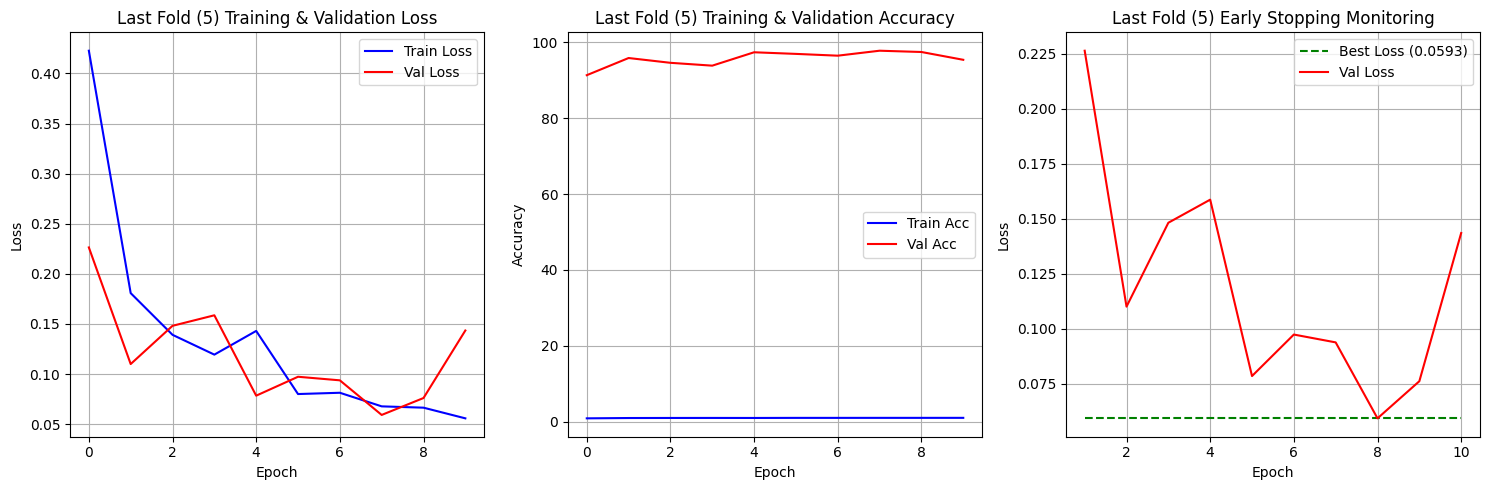

In [15]:


# 훈련 완료 후 그래프 그리기 (마지막 폴드의 학습 진행 상황)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fold_train_losses, label='Train Loss', color='blue')
plt.plot(fold_val_losses, label='Val Loss', color='red')
plt.title(f'Last Fold ({fold+1}) Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(fold_train_accuracies, label='Train Acc', color='blue')
plt.plot(fold_val_accuracies, label='Val Acc', color='red')
plt.title(f'Last Fold ({fold+1}) Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
early_stop_epochs = list(range(1, len(fold_train_losses) + 1))
plt.plot(early_stop_epochs, [early_stopping.best_loss] * len(early_stop_epochs),
         '--', label=f'Best Loss ({early_stopping.best_loss:.4f})', color='green')
plt.plot(early_stop_epochs, fold_val_losses, label='Val Loss', color='red')
plt.title(f'Last Fold ({fold+1}) Early Stopping Monitoring')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_progress_last_fold.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Weights & Biases에 그래프 기록 ---
# wandb.log({"training_progress_last_fold_plot": wandb.Image("training_progress_last_fold.png")})



📊 Performing Confusion Matrix Analysis on Last Fold's Validation Set

Confusion Matrix:
 [[400   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 400   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 400   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 382   5   0   1   6   0   0   0   0   0   2   4   0   0]
 [  0   0   0   6 389   0   0   1   0   0   0   0   0   0   4   0   0]
 [  0   0   0   0   0 400   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 398   0   0   0   1   1   0   0   0   0   0]
 [  0   0   0  67   8   0   0 311   0   0   2   2   0   1   9   0   0]
 [  0   0   1   0   0   1   0   0 397   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0 400   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 400   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1 398   0   1   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   1   0 398   0 

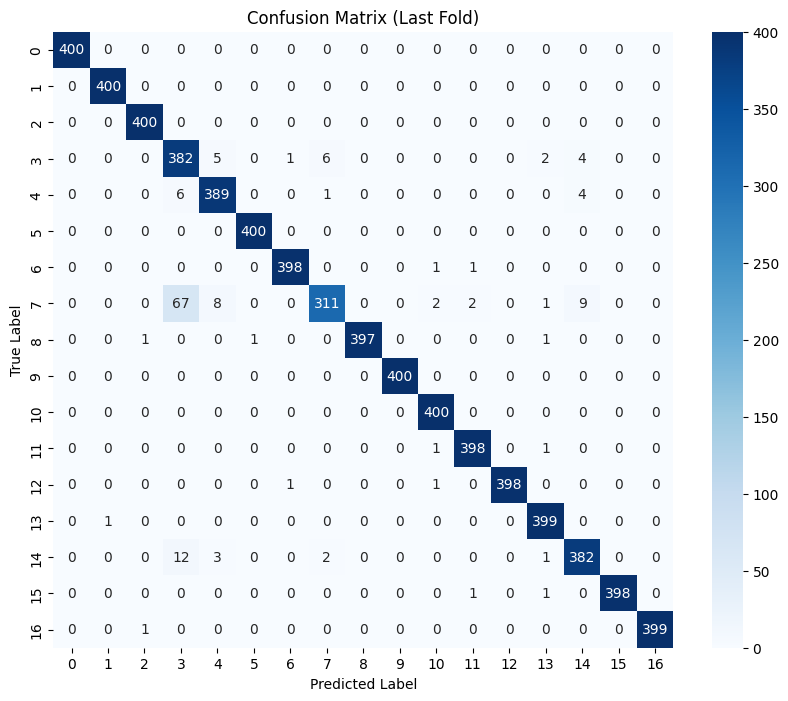

Confusion Matrix saved to confusion_matrix_last_fold.png

Class-wise Accuracy (Last Fold):
  Class 0 (True Count: 400): 1.0000
  Class 1 (True Count: 400): 1.0000
  Class 2 (True Count: 400): 1.0000
  Class 3 (True Count: 400): 0.9550
  Class 4 (True Count: 400): 0.9725
  Class 5 (True Count: 400): 1.0000
  Class 6 (True Count: 400): 0.9950
  Class 7 (True Count: 400): 0.7775
  Class 8 (True Count: 400): 0.9925
  Class 9 (True Count: 400): 1.0000
  Class 10 (True Count: 400): 1.0000
  Class 11 (True Count: 400): 0.9950
  Class 12 (True Count: 400): 0.9950
  Class 13 (True Count: 400): 0.9975
  Class 14 (True Count: 400): 0.9550
  Class 15 (True Count: 400): 0.9950
  Class 16 (True Count: 400): 0.9975
Confusion Matrix Analysis Completed.


In [16]:


# --- Confusion Matrix Analysis (마지막 폴드의 검증 결과) ---
print("\n" + "=" * 60, flush=True)
print("📊 Performing Confusion Matrix Analysis on Last Fold's Validation Set", flush=True)
print("=" * 60, flush=True)

if last_fold_true_labels and last_fold_predicted_labels:
    cm = confusion_matrix(last_fold_true_labels, last_fold_predicted_labels)
    print("\nConfusion Matrix:\n", cm, flush=True)

    class_names = [str(i) for i in range(NUM_CLASSES)] 

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Last Fold)')
    plt.savefig('confusion_matrix_last_fold.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion Matrix saved to confusion_matrix_last_fold.png", flush=True)

    # --- Weights & Biases에 혼동 행렬 기록 ---
    # wandb.log({"confusion_matrix_last_fold": wandb.Image("confusion_matrix_last_fold.png")})

    print("\nClass-wise Accuracy (Last Fold):", flush=True)
    for i, class_name in enumerate(class_names):
        true_positives = cm[i, i]
        total_in_class = np.sum(cm[i, :])
        if total_in_class > 0:
            accuracy = true_positives / total_in_class
            print(f"  Class {class_name} (True Count: {total_in_class}): {accuracy:.4f}", flush=True)
        else:
            print(f"  Class {class_name} (True Count: {total_in_class}): No samples in validation set.", flush=True)

else:
    print(f"Warning: No validation predictions collected for Confusion Matrix analysis in the last fold.", flush=True)

print("=" * 60, flush=True)
print("Confusion Matrix Analysis Completed.", flush=True)
print("=" * 60, flush=True)

# --- Weights & Biases 실행 종료 ---
# wandb.finish()
